In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd

pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
import os

# Optionally force tensorflow on CPU
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
test_set = False

In [4]:
import os
import tensorflow as tf
import keras
import numpy as np

from rule4ml.parsers.data_parser import (
    read_from_json,
    get_global_data,
    get_sequential_data,
    to_dataframe,
)

from rule4ml.parsers.data_parser import (
    default_board_map,
    default_strategy_map,
    default_layer_type_map,
)

base_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
test_path = os.path.join(base_path, "datasets", "trets", "test")

paths = os.path.join(base_path, "datasets", "iccad_submit", "preprocessed", "benchmark", "benchmark_vsynth_with_ii_fixed.json")\
    if not test_set else \
    [
        os.path.join(test_path, "2_20", "*.json"),
        os.path.join(test_path, "2layer", "*.json"),
        os.path.join(test_path, "3layer", "*.json"),
        os.path.join(test_path, "conv1d", "*.json"),
        os.path.join(test_path, "conv2d", "*.json"),
        os.path.join(test_path, "latency", "*.json"),
        os.path.join(test_path, "resource", "*.json"),
    ]
json_data = read_from_json(paths, batch_size=1, max_workers=1)

meta_data, global_inputs, targets = get_global_data(json_data, max_workers=16)
sequential_inputs = get_sequential_data(json_data, max_workers=16)

# Ordinal encoding of categorical inputs
global_categorical_maps = {
    "strategy": default_strategy_map,
    "board": default_board_map,
}
sequential_categorical_maps = {
    "layer_type": default_layer_type_map,
}

test_df = to_dataframe(
    meta_data=meta_data,
    global_inputs=global_inputs,
    sequential_inputs=sequential_inputs,
    global_categorical_maps=global_categorical_maps,
    sequential_categorical_maps=sequential_categorical_maps,
    targets=targets,
)

seed_num = 1337
np.random.seed(seed_num)
keras.utils.set_random_seed(seed_num)
tf.config.experimental.enable_op_determinism()

feature_labels = [
    "strategy",
    "board",
    "bit_width",
    "reuse_mean",
    "dense_inputs_mean",
    "dense_outputs_mean",
    "dense_parameters_mean",
    "dense_reuse_mean",
    "dense_count",
    "conv1d_inputs_mean",
    "conv1d_outputs_mean",
    "conv1d_parameters_mean",
    "conv1d_filters_mean",
    "conv1d_kernel_size_mean",
    "conv1d_strides_mean",
    "conv1d_reuse_mean",
    "conv1d_count",
    "conv2d_inputs_mean",
    "conv2d_outputs_mean",
    "conv2d_parameters_mean",
    "conv2d_filters_mean",
    "conv2d_kernel_size_mean",
    "conv2d_strides_mean",
    "conv2d_reuse_mean",
    "conv2d_count",
    "batchnormalization_inputs_mean",
    "batchnormalization_outputs_mean",
    "batchnormalization_parameters_mean",
    "batchnormalization_count",
    "add_count",
    "concatenate_count",
    "dropout_count",
    "relu_count",
    "sigmoid_count",
    "tanh_count",
    "softmax_inputs_mean",
    "softmax_outputs_mean",
    "softmax_count",
]
print(len(test_df))

2025-06-06 11:34:51.393704: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-06 11:34:51.771146: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-06 11:34:51.771181: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-06 11:34:51.836492: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-06 11:34:51.936518: I tensorflow/core/platform/cpu_feature_guar

887


In [5]:
test_df = test_df.dropna(subset=["bram", "dsp", "ff", "lut", "cycles", "interval"])
print(len(test_df))

886


In [6]:
# test_df.head()

In [ ]:
from rule4ml.models.wrappers import KerasModelWrapper
from rule4ml.parsers.data_parser import boards_data, default_board_map

test_inputs_df = test_df[feature_labels].copy()
print(f"Test Inputs: {test_inputs_df.shape}")

prediction_labels = ["bram", "dsp", "ff", "lut", "cycles", "interval"]
test_targets_df = test_df[prediction_labels].copy()

wrappers = []
abs_errors = []
sape_errors = []
normed_errors = []
relative_percentage_errors = []

gns = { x: None for x in prediction_labels }
preds = { x: None for x in prediction_labels }

r2_scores = { x: None for x in prediction_labels }
smape_scores = { x: None for x in prediction_labels }
rmse_scores = { x: None for x in prediction_labels }
average_inference_times = { x: None for x in prediction_labels }
for label in prediction_labels:
    wrapper = KerasModelWrapper()
    wrapper.load(
        f"./models/trets/{label.upper()}_MLP_config.json",
        f"./models/trets/{label.lower()}_best.weights.h5",
    )
    wrappers.append(wrapper)

    print("=" * 80)
    print(f"Predicting {label.upper()}...")
    pred, r2, smape_value, rmse_value, avg_inference_time = wrapper.predict_from_df(
        test_inputs_df, test_targets_df[label].values, verbose=2
    )
    pred = pred.squeeze()

    r2_scores[label] = r2
    smape_scores[label] = smape_value
    rmse_scores[label] = rmse_value
    average_inference_times[label] = avg_inference_time

    gn = test_targets_df[label].values

    abs_errors.append(np.abs(gn - pred))
    sape_errors.append(2 * np.abs(gn - pred) / (np.abs(gn) + np.abs(pred) + 1e-6))

    board_name = ""
    for board, board_id in default_board_map.items():
        if board_id == test_inputs_df["board"].values[0]:
            board_name = board
            break

    if label not in ["cycles", "interval"]:
        max_vals = boards_data[board_name][f"max_{label}"]
        normed_gn = np.maximum(1 / max_vals, np.minimum(gn / max_vals, 2.0)) * 100
        normed_pred = np.maximum(1 / max_vals, np.minimum(pred / max_vals, 2.0)) * 100
        normed_errors.append(normed_gn - normed_pred)
    else:
        normed_errors.append(np.abs(gn - pred))

    rpe = ((gn - pred) / (gn + 1)) * 100
    relative_percentage_errors.append(rpe)

    gns[label] = gn
    preds[label] = pred

print("=" * 80)
print("Summary")
print(f"Average R2 Score: {np.mean(list(r2_scores.values()))}")
print(f"Average SMAPE Score: {np.mean(list(smape_scores.values()))}")
print(f"Average RMSE Score: {np.mean(list(rmse_scores.values()))}")
print("Average Inference Time: {:.2E} seconds".format(np.mean(list(average_inference_times.values()))))

Test Inputs: (886, 38)
Predicting BRAM...
28/28 - 0s - 162ms/epoch - 6ms/step
R2 Score: -0.4
SMAPE: 84.6%
RMSE: 2.9
Average Inference Time: 2.39E-04 seconds
Predicting DSP...
28/28 - 0s - 75ms/epoch - 3ms/step
R2 Score: 0.1
SMAPE: 89.3%
RMSE: 766.8
Average Inference Time: 1.08E-04 seconds
Predicting FF...
28/28 - 0s - 75ms/epoch - 3ms/step
R2 Score: 0.5
SMAPE: 62.9%
RMSE: 12057.6
Average Inference Time: 1.09E-04 seconds
Predicting LUT...
28/28 - 0s - 61ms/epoch - 2ms/step
R2 Score: 0.3
SMAPE: 71.9%
RMSE: 22546.1
Average Inference Time: 9.39E-05 seconds
Predicting CYCLES...
28/28 - 0s - 75ms/epoch - 3ms/step
R2 Score: 0.5
SMAPE: 82.6%
RMSE: 877.4
Average Inference Time: 1.11E-04 seconds
Predicting INTERVAL...
28/28 - 0s - 71ms/epoch - 3ms/step
R2 Score: 0.5
SMAPE: 86.1%
RMSE: 372.9
Average Inference Time: 1.45E-04 seconds
Summary
Average R2 Score: 0.2484416112399878
Average SMAPE Score: 79.58770997730443
Average RMSE Score: 6103.96940900344
Average Inference Time: 1.34E-04 seconds


In [ ]:
def get_architecture_name(model_name):
    architecture = model_name.split("_")[0].split("/")[-1]
    if architecture.lower() in ["model", "2layer", "3layer", "latency", "resource"]:
        architecture = "dense"
    return architecture

from rule4ml.models.wrappers import KerasModelWrapper
from rule4ml.parsers.data_parser import boards_data, default_board_map

test_df["architecture"] = test_df["model_name"].apply(get_architecture_name)
unique_architectures = test_df["architecture"].unique()

gns = { x: {} for x in unique_architectures }
preds = { x: {} for x in unique_architectures }

prediction_labels = ["bram", "dsp", "ff", "lut", "cycles", "interval"]
all_relative_percentage_errors = { x: np.array([]) for x in prediction_labels }

for architecture in unique_architectures:
    architecture_df = test_df[test_df["architecture"] == architecture]
    test_inputs_df = architecture_df[feature_labels].copy()
    print("=" * 80)
    print(f"Test Inputs: {test_inputs_df.shape}")
    print(f"Architecture: {architecture}")

    test_targets_df = architecture_df[prediction_labels].copy()

    gns[architecture] = {x : None for x in prediction_labels}
    preds[architecture] = {x : None for x in prediction_labels}

    wrappers = []
    abs_errors = []
    sape_errors = []
    normed_errors = []
    relative_percentage_errors = []

    r2_scores = []
    smape_scores = []
    rmse_scores = []
    average_inference_times = []

    for label in prediction_labels:
        wrapper = KerasModelWrapper()
        wrapper.load(
            f"./models/trets/{label.upper()}_MLP_config.json",
            f"./models/trets/{label.lower()}_best.weights.h5",
        )
        wrappers.append(wrapper)
        wrapper.predict_from_df(test_inputs_df)

        print("=" * 80)
        print(f"Predicting {label.upper()}...")
        pred, r2, smape_value, rmse_value, avg_inference_time = wrapper.predict_from_df(
            test_inputs_df, test_targets_df[label].values, verbose=2
        )
        pred = pred.squeeze()

        r2_scores.append(r2)
        smape_scores.append(smape_value)
        rmse_scores.append(rmse_value)
        average_inference_times.append(avg_inference_time)

        gn = test_targets_df[label].values

        abs_errors.append(np.abs(gn - pred))
        sape_errors.append(2 * np.abs(gn - pred) / (np.abs(gn) + np.abs(pred) + 1e-6))

        board_name = ""
        for board, board_id in default_board_map.items():
            if board_id == test_inputs_df["board"].values[0]:
                board_name = board
                break

        if label not in ["cycles", "interval"]:
            max_vals = boards_data[board_name][f"max_{label}"]
            normed_gn = np.maximum(1 / max_vals, np.minimum(gn / max_vals, 2.0)) * 100
            normed_pred = np.maximum(1 / max_vals, np.minimum(pred / max_vals, 2.0)) * 100
            normed_errors.append(normed_gn - normed_pred)
        else:
            normed_errors.append(np.abs(gn - pred))

        relative_percentage_errors.append(((gn - pred) / (gn + 1)) * 100)

        gns[architecture][label] = gn
        preds[architecture][label] = pred

        all_relative_percentage_errors[label] = np.append(all_relative_percentage_errors[label], relative_percentage_errors)

    print("=" * 80)
    print("Summary")
    print(f"Average R2 Score: {np.mean(r2_scores)}")
    print(f"Average SMAPE Score: {np.mean(smape_scores)}")
    print(f"Average RMSE Score: {np.mean(rmse_scores)}")
    print("Average Inference Time: {:.2E} seconds".format(np.mean(average_inference_times)))

Test Inputs: (119, 38)
Architecture: Bipc
Predicting BRAM...
4/4 - 0s - 17ms/epoch - 4ms/step
R2 Score: -0.7
SMAPE: 107.7%
RMSE: 3.4
Average Inference Time: 3.14E-04 seconds
Predicting DSP...
4/4 - 0s - 17ms/epoch - 4ms/step
R2 Score: -0.0
SMAPE: 127.0%
RMSE: 1719.2
Average Inference Time: 3.00E-04 seconds
Predicting FF...
4/4 - 0s - 18ms/epoch - 4ms/step
R2 Score: 0.2
SMAPE: 77.2%
RMSE: 24472.0
Average Inference Time: 3.21E-04 seconds
Predicting LUT...
4/4 - 0s - 17ms/epoch - 4ms/step
R2 Score: 0.0
SMAPE: 82.3%
RMSE: 48867.4
Average Inference Time: 3.12E-04 seconds
Predicting CYCLES...
4/4 - 0s - 18ms/epoch - 4ms/step
R2 Score: 0.4
SMAPE: 75.9%
RMSE: 1821.4
Average Inference Time: 3.12E-04 seconds
Predicting INTERVAL...
4/4 - 0s - 18ms/epoch - 4ms/step
R2 Score: 0.4
SMAPE: 70.6%
RMSE: 573.6
Average Inference Time: 3.38E-04 seconds
Summary
Average R2 Score: 0.05118573179353678
Average SMAPE Score: 90.123686195821
Average RMSE Score: 12909.497196829625
Average Inference Time: 3.16E-04 s

/tmp/ipykernel_6293/1442370845.py:42: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax_pred.set_xscale("log")


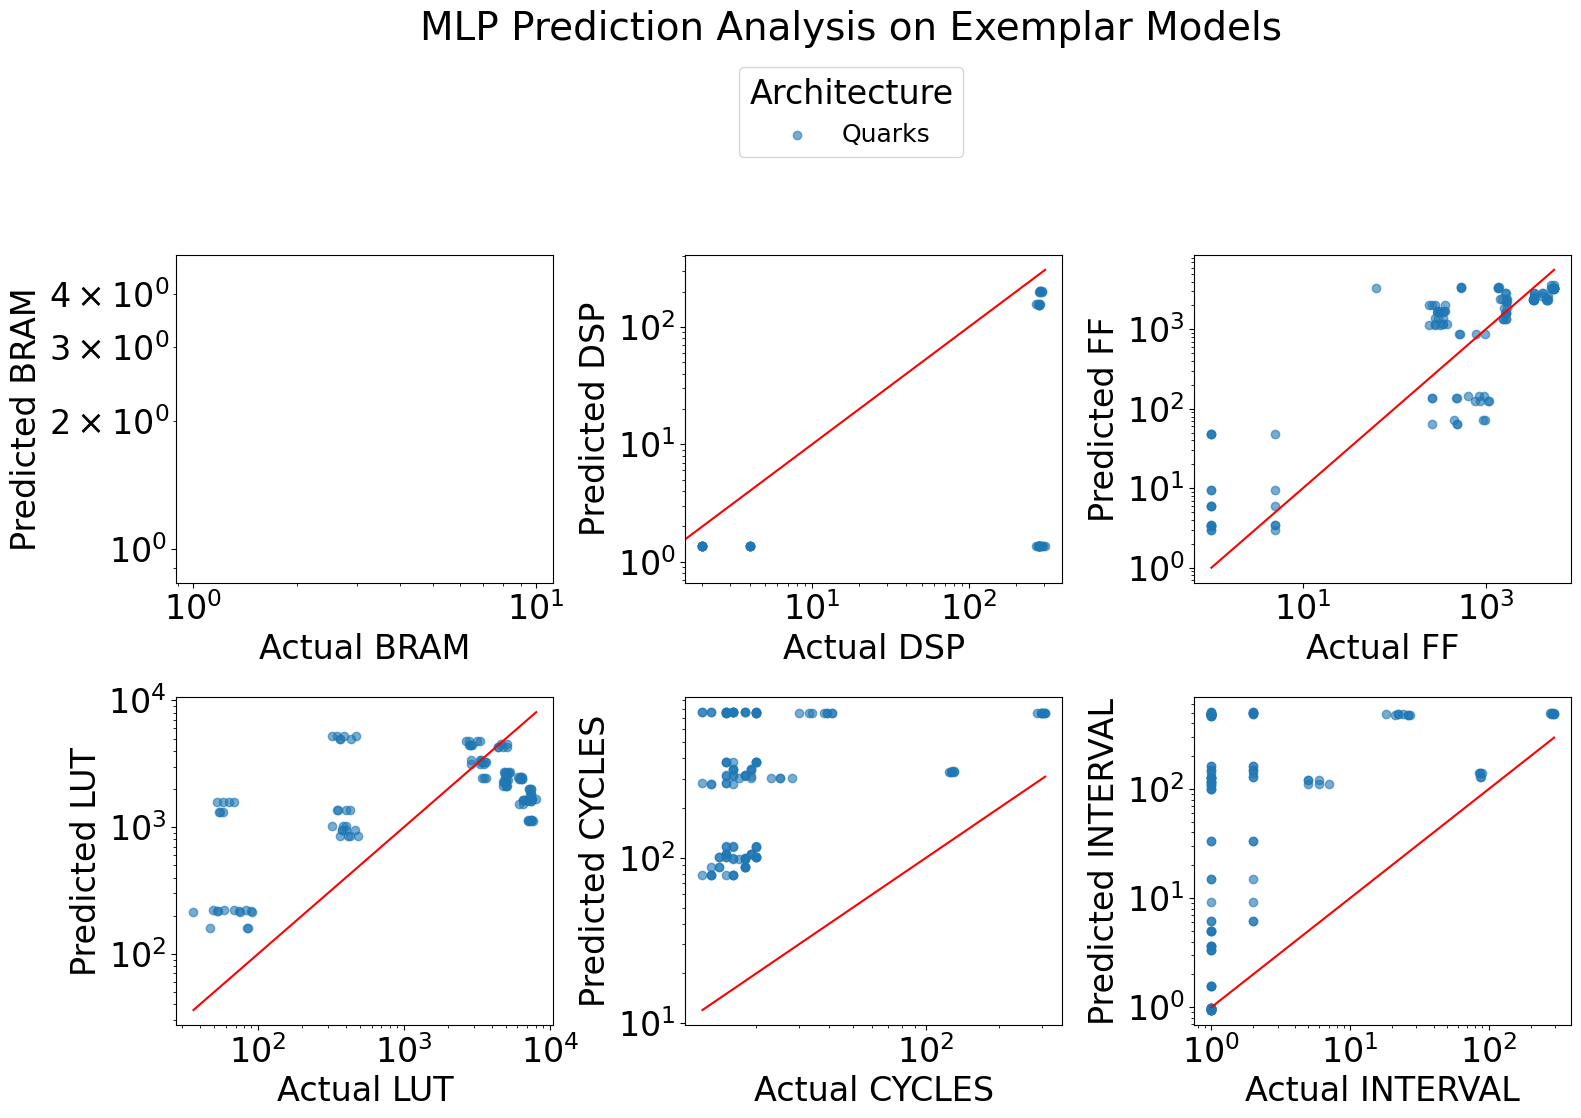

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({"font.size": 24})

unique_architectures = test_df["architecture"].unique()
prediction_labels = ["bram", "dsp", "ff", "lut", "cycles", "interval"]
num_plots = len(prediction_labels)
num_y = int(np.sqrt(num_plots))
num_x = int(np.ceil(np.sqrt(num_plots)))

fig, axes = plt.subplots(num_y, num_x, figsize=(6 * num_x, 10))
axes = np.reshape(axes, -1)
fig.subplots_adjust(hspace=0.35, wspace=0.35)

for i, label in enumerate(prediction_labels):
    ax_pred = axes[i]

    actual = []
    predicted = []
    scatters = []
    for architecture in unique_architectures:
        actual.extend(gns[architecture][label])
        predicted.extend(preds[architecture][label])

        scatters.append(
            ax_pred.scatter(
                gns[architecture][label],
                preds[architecture][label],
                alpha=0.6,
                label=architecture[0].upper() + architecture[1:]
            )
        )

    # Predicted vs. Actual
    ax_pred.plot([min(actual), max(actual)], [min(actual), max(actual)], color="red")
    ax_pred.set_xlabel(f"Actual {label.upper()}")
    ax_pred.set_ylabel(f"Predicted {label.upper()}")
    ax_pred.set_xscale("log")
    ax_pred.set_yscale("log")

y_legend = 1.03 if test_set else 1.08
y_title = 1.08 if test_set else 1.125
legend = fig.legend(
    handles=scatters, title="Architecture", loc="upper center", bbox_to_anchor=(0.5, y_legend), fontsize=18, ncol=3
)
title = f"MLP Prediction Analysis on {'Test Set' if test_set else 'Exemplar Models'}"
suptitle = fig.suptitle(title, fontsize=28, x=0.5, y=y_title)

plt.show()

In [11]:
filename = "benchmark_scatter.png" if not test_set else "test_set_scatter.png"
fig.savefig(
    filename,
    dpi=300,
    bbox_extra_artists=(suptitle, legend),
    bbox_inches="tight",
)

6


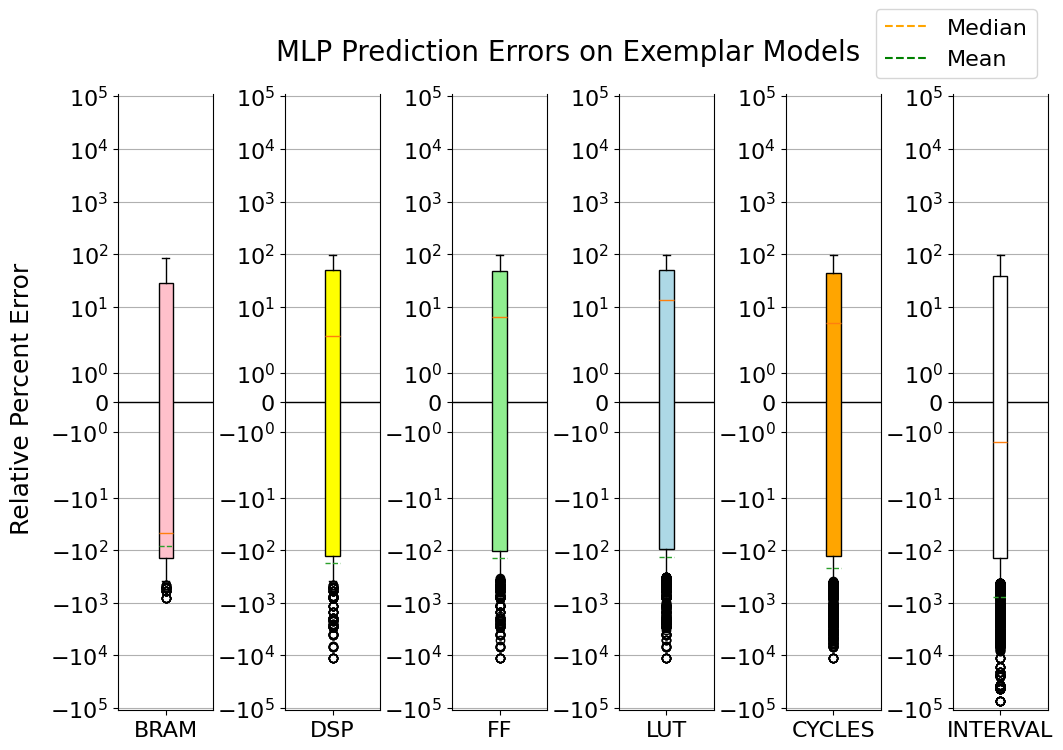

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

plt.rcParams.update({"font.size": 16})

print(len(all_relative_percentage_errors))
fig, axis = plt.subplots(1, len(all_relative_percentage_errors), figsize=(12, 8))
axis = np.reshape(axis, -1)
fig.subplots_adjust(hspace=0.1, wspace=0.75)

iqr_weight = 1.5
colors = ["pink", "yellow", "lightgreen", "lightblue", "#FFA500", "white"]

max_abs = np.nanmax(
    [np.nanmax(np.abs(errors)) for errors in all_relative_percentage_errors.values()]
) * 1.5

for i, label in enumerate(all_relative_percentage_errors.keys()):
    errors = all_relative_percentage_errors[label]
    ax = axis[i]

    ax.axhline(0, color='black', linestyle='-', linewidth=1)

    bplot = ax.boxplot(
        errors,
        whis=iqr_weight,
        tick_labels=[label.upper()],
        showfliers=True,
        showmeans=True,
        meanline=True,
        vert=True,
        patch_artist=True,
    )

    for j, patch in enumerate(bplot["boxes"]):
        patch.set_facecolor(colors[(i + j) % len(colors)])

    ax.yaxis.grid(True)
    ax.spines.top.set_visible(False)
    ax.xaxis.tick_bottom()
    ax.set_yscale("symlog")

    ax.set_ylim(-max_abs, max_abs)

median_line = Line2D([0], [0], color="orange", linestyle="--", linewidth=1.5, label="Median")
mean_line = Line2D([0], [0], color="green", linestyle="--", linewidth=1.5, label="Mean")

handles = [median_line, mean_line]
labels = ["Median", "Mean"]

legends = fig.legend(
    handles,
    labels,
    bbox_to_anchor=[0.9, 1],
    loc="upper right",
    ncol=len(labels) // 2,
)

ytext = fig.text(0.035, 0.5, "Relative Percent Error", va="center", rotation="vertical", size=18)
title = f"MLP Prediction Errors on {'Test Set' if test_set else 'Exemplar Models'}"
suptitle = fig.suptitle(title, fontsize=20, y=0.95)

plt.show()

In [12]:
filename = "benchmark_boxplot.png" if not test_set else "test_set_boxplot.png"
fig.savefig(
    filename,
    dpi=300,
    bbox_extra_artists=(legends, ytext, suptitle),
    bbox_inches="tight",
)